In [ ]:
import energyflow as ef
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchsummary import summary
#oirusfhvcosil


In [ ]:
pts = []
etas = []
gen_pts = []
area=[]
npvs=[]
jec=[]

data = ef.mod.load(amount=0.1, cache_dir='~/.energyflow',
                    dataset='sim', subdatasets=None) 
for j in range(len(data.jet_pts)):

    pts.append(data.jet_pts[j])
    etas.append(data.jet_etas[j])
    area.append(data.jet_areas[j])
    npvs.append(data.npvs[j])
    gen_pts.append(data.gen_jet_pts[j])
    jec.append(data.jecs[j])

x=np.transpose(np.array([pts,etas,area,npvs,gen_pts]))
y=np.array(jec)



In [3]:
from sklearn.model_selection import train_test_split
x_train_0, x_test_0, y_train_0, y_test_0 = train_test_split(x, y, test_size=0.2, shuffle=True)
x_train_0,x_vali_0,y_train_0,y_vali_0 = train_test_split(x_train_0 , y_train_0 , test_size=0.4, shuffle=True)



In [4]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# Fit the scaler on the training data and transform the training, validation, and test data
x_train_0 = scaler_x.fit_transform(x_train_0)
x_vali_0 = scaler_x.transform(x_vali_0)
x_test_0 = scaler_x.transform(x_test_0)

y_train_0 = scaler_y.fit_transform(y_train_0.reshape(-1, 1)).flatten()
y_vali_0 = scaler_y.transform(y_vali_0.reshape(-1, 1)).flatten()
y_test_0 = scaler_y.transform(y_test_0.reshape(-1, 1)).flatten()

In [5]:
from torch.utils.data import DataLoader, TensorDataset
x_train = torch.tensor(x_train_0[:, :-1], dtype=torch.float32)
y_train = torch.tensor(y_train_0, dtype=torch.float32)
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=512, shuffle=True)

y_vali = torch.tensor(y_vali_0, dtype=torch.float32)
x_vali = torch.tensor(x_vali_0[:, :-1], dtype=torch.float32)
vali_ds = TensorDataset(x_vali, y_vali)
vali_dl = DataLoader(vali_ds, batch_size=512, shuffle=True)

print(x_train.shape, y_train.shape, x_vali.shape, y_vali.shape)

torch.Size([1782536, 4]) torch.Size([1782536]) torch.Size([1188358, 4]) torch.Size([1188358])


In [6]:
# controlliamo se la GPU è disponibile e nel caso quale tipo di GPU
if torch.cuda.is_available():
  print('Numero di GPU disponibili: ',torch.cuda.device_count())
  for i in range(0,torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))

# se la GPU è disponibile setto device='cuda', altrimenti 'cpu
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Computation device: cpu



In [32]:
class ShallowMLP(nn.Module):
  def __init__(self, input_dim=4, output_dim=1, first_hidden_dim=128,second_hidden_dim=128,third_hidden_dim=128):
    super(ShallowMLP, self).__init__()

    # inizializzazione dei layer/funzioni che utilizzeremo per definire la rete

    #torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
    self.layer1 = nn.Linear(input_dim, first_hidden_dim)  #hidden layer
    self.layer2 = nn.Linear(first_hidden_dim, first_hidden_dim)
    self.layer3 = nn.Linear(first_hidden_dim, second_hidden_dim)

    self.layer4 = nn.Linear(second_hidden_dim, third_hidden_dim) 
    self.layer5 = nn.Linear(third_hidden_dim, output_dim)

    self.relu = nn.ReLU() # relu function (NOTA: non è obbligatorio definirla qui, è anche possible usare la forma funzionale F.relu() direttamente nel metodo forward())


  def forward(self, x):
    x = self.layer1(x)
    x = self.relu(x) 
    x = self.layer2(x)
    x = self.relu(x)
    x= self.layer3(x)
    x = self.relu(x)
    x = self.layer4(x)
    x = self.relu(x)
    out = self.layer5(x)
    
    return out
  

model = ShallowMLP()
summary(model, (4,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             640
              ReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 128]          16,512
              ReLU-4                  [-1, 128]               0
            Linear-5                  [-1, 128]          16,512
              ReLU-6                  [-1, 128]               0
            Linear-7                  [-1, 128]          16,512
              ReLU-8                  [-1, 128]               0
            Linear-9                    [-1, 1]             129
Total params: 50,305
Trainable params: 50,305
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.19
Estimated Total Size (MB): 0.20
---------------------------------------------

In [33]:
#testiamo il modello
x,_ = next(iter(train_dl)) #è un AE non ci servono le label
x=x.to(device)
xtilde = model(x)
print(xtilde.shape)

torch.Size([512, 1])


In [34]:
class SaveBestModel:
    def __init__(self, best_valid_loss=float('inf')): #object initialized with best_loss = +infinite
        self.best_valid_loss = best_valid_loss

    def __call__(self, current_valid_loss, epoch, model, optimizer, criterion):

        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss

            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")



            torch.save({'model' : model,
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss function': criterion,
                'loss': current_valid_loss,
                }, 'best_model_jecs.pt')

            return 1
        else:
          return 0

#carica il modello
def load_model(save_path='/content/best_model_jecs.pt', model_class=None):
    checkpoint = torch.load(save_path,map_location=torch.device('cpu') )

    model = model_class()

    model.load_state_dict(checkpoint['model_state_dict'])

    return model

In [35]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/40, Train Loss: 0.187224305, Validation Loss: 0.162620983

Best validation loss: 0.16262098296076205

Saving best model for epoch: 1

Epoch 2/40, Train Loss: 0.149272516, Validation Loss: 0.153589476

Best validation loss: 0.15358947579847312

Saving best model for epoch: 2

Epoch 3/40, Train Loss: 0.143058669, Validation Loss: 0.152467661

Best validation loss: 0.15246766112276428

Saving best model for epoch: 3

Epoch 4/40, Train Loss: 0.139355411, Validation Loss: 0.137485455

Best validation loss: 0.1374854545639334

Saving best model for epoch: 4

Epoch 5/40, Train Loss: 0.137855854, Validation Loss: 0.138913724
Epoch 6/40, Train Loss: 0.135971879, Validation Loss: 0.140008938
Epoch 7/40, Train Loss: 0.134406610, Validation Loss: 0.134307430

Best validation loss: 0.13430743004520335

Saving best model for epoch: 7

Epoch 8/40, Train Loss: 0.133542678, Validation Loss: 0.129391394

Best validation loss: 0.12939139421188567

Saving best model for epoch: 8

Epoch 9/40, Train

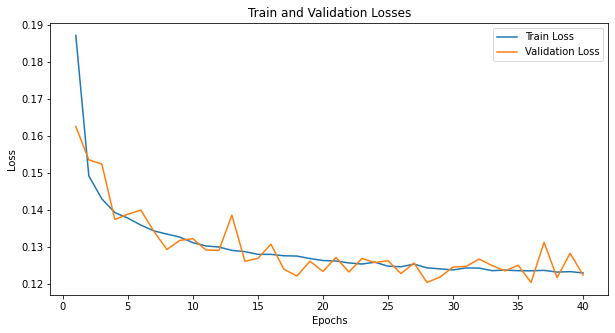

In [36]:
num_epochs = 40

save_best_model = SaveBestModel()

train_losses = []
vali_losses = []

for epoch in range(num_epochs):
    #training
    model.train()
    running_loss = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    
    train_loss = running_loss / len(train_dl.dataset)
    train_losses.append(train_loss)
    
    #validation step
    model.eval()
    running_vali_loss = 0.0
    with torch.no_grad():
        for xb, yb in vali_dl:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb.unsqueeze(1))
            running_vali_loss += loss.item() * xb.size(0)
    
    vali_loss = running_vali_loss / len(vali_dl.dataset)
    vali_losses.append(vali_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.9f}, Validation Loss: {vali_loss:.9f}")

    # Save the model
    save_best_model(vali_loss, epoch, model, optimizer, criterion)

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), vali_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Losses')
plt.legend()
plt.show()

In [37]:
# Evaluate the model on the test set
model= load_model('best_model_jecs.pt', model_class=lambda: ShallowMLP())
model.to(device)
model.eval()
x_test_tensor = torch.tensor(x_test_0, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_0, dtype=torch.float32)


In [38]:
print(x_test_tensor.shape, y_test_tensor.unsqueeze(1).shape)

torch.Size([742724, 5]) torch.Size([742724, 1])


Test MSE: 0.12106049805879593


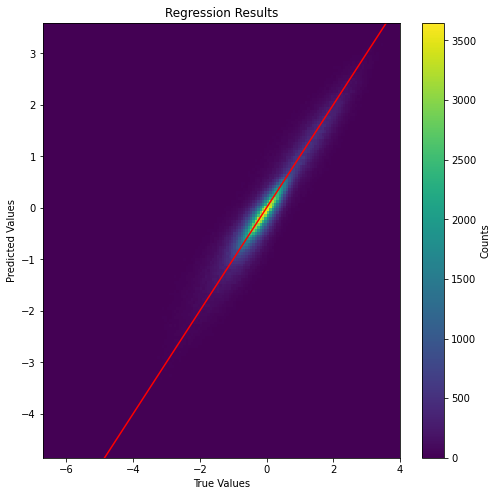

In [39]:

with torch.no_grad():
    y_pred_tensor = model(x_test_tensor[:,:-1])
    test_loss = criterion(y_pred_tensor, y_test_tensor.unsqueeze(1)).item()
print(f"Test MSE: {test_loss}")

# Scatter plot of true vs predicted values
plt.figure(figsize=(8, 8))
plt.hist2d(y_test_tensor.numpy().flatten(), y_pred_tensor.numpy().flatten(), bins=150, cmap='viridis')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Regression Results')
plt.plot([min(y_test_tensor.numpy().flatten()), max(y_test_tensor.numpy().flatten())], [min(y_test_tensor.numpy().flatten()), max(y_test_tensor.numpy().flatten())], color='red')  # Perfect fit line
plt.colorbar(label='Counts')
plt.show()


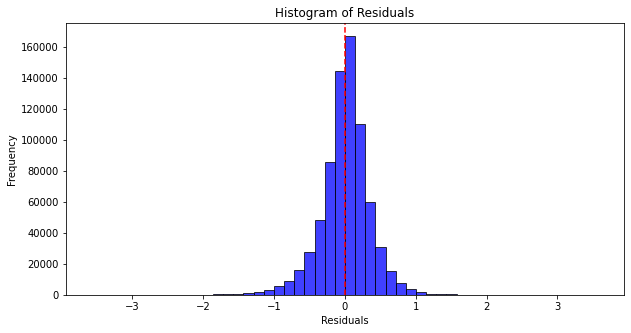

In [40]:
# Calculate residuals
residuals = y_test_tensor.numpy().flatten()-y_pred_tensor.numpy().flatten()

# Plot histogram of residuals
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=50, alpha=0.75, color='blue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

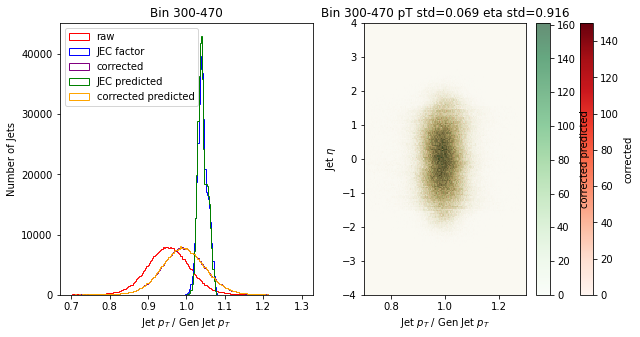

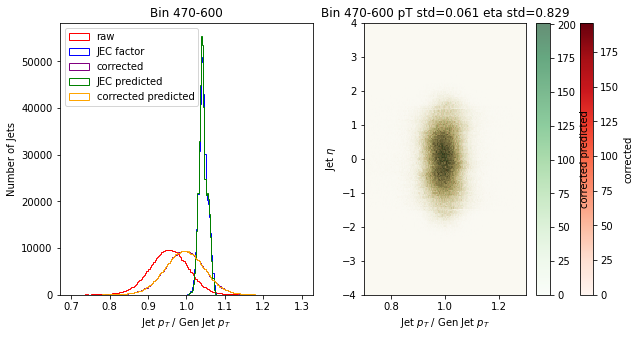

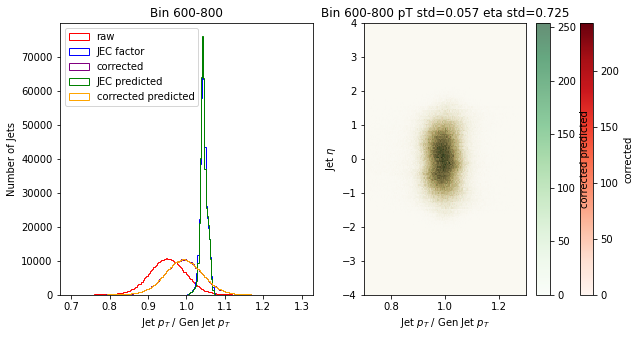

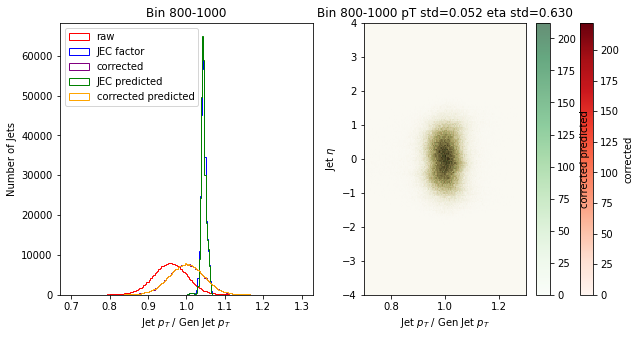

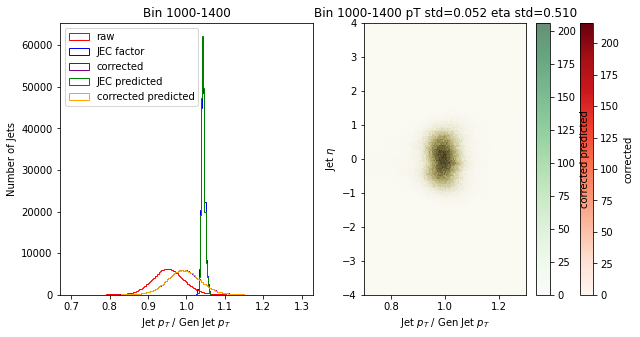

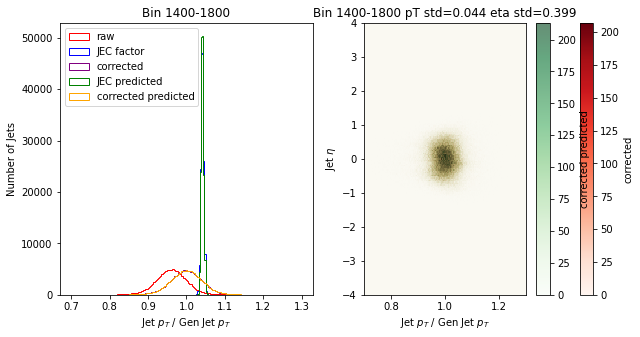

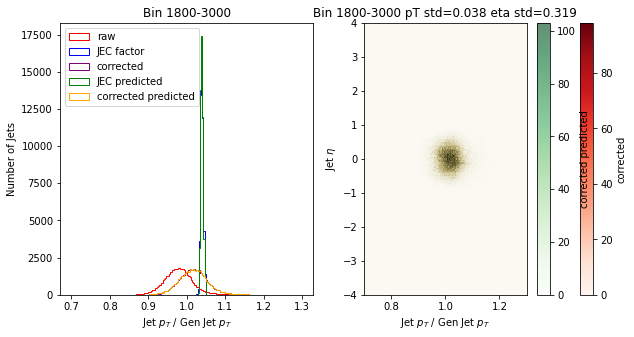

In [41]:
bins=np.array([300,470,600,800,1000,1400,1800,3000])
# Unify test and validation sets
x_test_vali = np.concatenate((x_test_0, x_vali_0), axis=0)
y_test_vali = np.concatenate((y_test_0, y_vali_0), axis=0)
mask_variable=scaler_x.inverse_transform(x_test_vali)[:,0]
# Apply the mask to the unified test and validation sets
for i in range(len(bins) - 1):
    mask = (np.array(mask_variable) >= bins[i]) & (np.array(mask_variable) < bins[i + 1])
    
    # Prepare the input for the model
    x_bin = x_test_vali[mask][:, :-1]
    x_bin_tensor = torch.tensor(x_bin, dtype=torch.float32).to(device)

    # Predict JEC using the model
    with torch.no_grad():
        jec_pred_tensor = model(x_bin_tensor).cpu().numpy().flatten()
    
    # Denormalize the predicted JEC
    jec_pred = scaler_y.inverse_transform(jec_pred_tensor.reshape(-1, 1)).flatten()

    x_prime = scaler_x.inverse_transform(x_test_vali[mask])
    y_prime = scaler_y.inverse_transform(y_test_vali[mask].reshape(-1, 1)).flatten()
    pts_bin = np.array(x_prime[:,0])
    gen_pts_bin = np.array(x_prime[:,4])
    jec_bin = np.array(y_prime)
    etas_bin = np.array(x_prime[:,1])

    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # Adjusted figsize for better visualization

    # Plot 1D histograms
    ax[0].hist(pts_bin / gen_pts_bin, bins=np.linspace(0.7, 1.3, 200), histtype="step", color="red", label="raw")
    ax[0].hist(jec_bin, bins=np.linspace(0.7, 1.3, 200), histtype="step", color="blue", label="JEC factor")
    ax[0].hist(pts_bin * jec_bin / gen_pts_bin, bins=np.linspace(0.7, 1.3, 200), histtype="step", color="purple", label="corrected")
    ax[0].hist(jec_pred, bins=np.linspace(0.7, 1.3, 200), histtype="step", color="green", label="JEC predicted")
    ax[0].hist(pts_bin * jec_pred / gen_pts_bin, bins=np.linspace(0.7, 1.3, 200), histtype="step", color="orange", label="corrected predicted")
    ax[0].set_xlabel("Jet $p_T$ / Gen Jet $p_T$")
    ax[0].set_ylabel("Number of Jets")
    ax[0].set_title(f"Bin {bins[i]}-{bins[i + 1]}")
    ax[0].legend()

    # Plot 2D histograms
    #h1 = ax[1].hist2d(pts_bin / gen_pts_bin, etas_bin, 
    #                  bins=[np.linspace(0.7, 1.3, 200), np.linspace(-4, 4, 200)], cmap='Reds',alpha=0, label="raw")

    h2 = ax[1].hist2d(pts_bin * jec_bin / gen_pts_bin, etas_bin, 
                      bins=[np.linspace(0.7, 1.3, 200), np.linspace(-4, 4, 200)], cmap='Reds', alpha=1, label="corrected")

    h3 = ax[1].hist2d(pts_bin * jec_pred / gen_pts_bin, etas_bin, 
                      bins=[np.linspace(0.7, 1.3, 200), np.linspace(-4, 4, 200)], cmap='Greens', alpha=0.6, label="corrected predicted")

    ax[1].set_xlabel("Jet $p_T$ / Gen Jet $p_T$")
    ax[1].set_ylabel("Jet $\eta$")
    ax[1].set_title(f"Bin {bins[i]}-{bins[i + 1]} pT std={np.std(pts_bin / gen_pts_bin):.3f} eta std={np.std(etas_bin):.3f}")

    # Add colorbars
    #plt.colorbar(h1[3], ax=ax[1], label='raw')
    plt.colorbar(h2[3], ax=ax[1], label='corrected')
    plt.colorbar(h3[3], ax=ax[1], label='corrected predicted')

    plt.show()


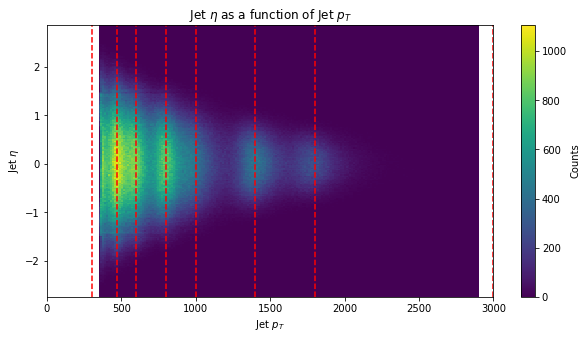

In [42]:

plt.figure(figsize=(10, 5))
plt.hist2d(pts, etas, bins=[200, 200], cmap='viridis')
plt.xlabel('Jet $p_T$')
plt.ylabel('Jet $\eta$')
plt.title('Jet $\eta$ as a function of Jet $p_T$')
plt.colorbar(label='Counts')

# Plot vertical lines for each bin value
for bin_value in bins:
    plt.axvline(x=bin_value, color='red', linestyle='--')

plt.xlim(0, 3000)

plt.show()


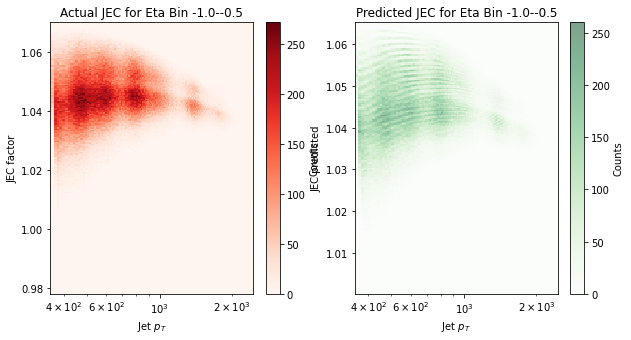

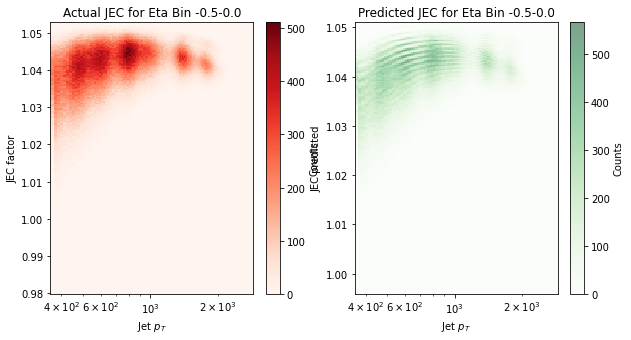

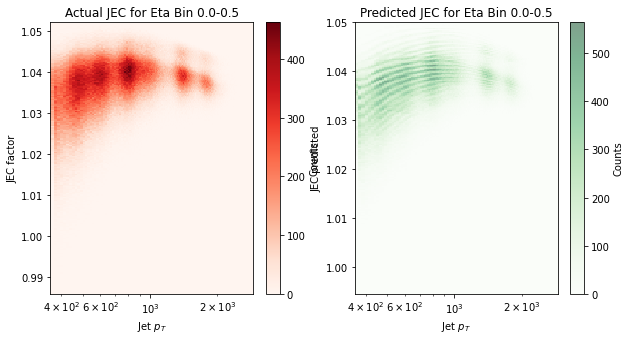

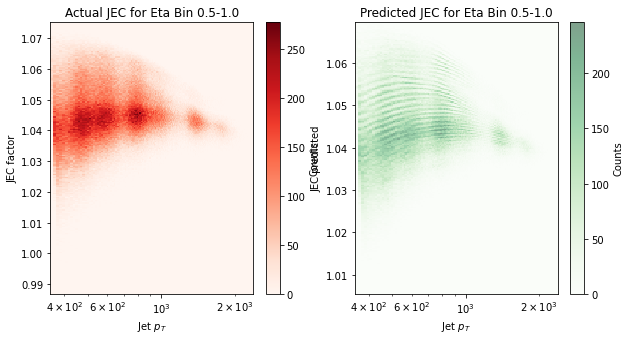

In [43]:
eta_bins = np.linspace(-1, 1, 5)

for i in range(len(eta_bins) - 1):
    mask = (np.array(etas) >= eta_bins[i]) & (np.array(etas) < eta_bins[i + 1])
    pts_bin = np.array(pts)[mask]
    gen_pts_bin = np.array(gen_pts)[mask]
    jec_bin = np.array(jec)[mask]
    etas_bin = np.array(etas)[mask]

    if len(pts_bin) == 0:
        continue

    # Prepare the input for the model
    x_bin = np.transpose(np.array([pts_bin, etas_bin, np.array(area)[mask], np.array(npvs)[mask], gen_pts_bin]))
    x_bin = scaler_x.transform(x_bin)
    x_bin_tensor = torch.tensor(x_bin[:,:-1], dtype=torch.float32).to(device)

    # Predict JEC using the model
    with torch.no_grad():
        jec_pred_tensor = model(x_bin_tensor).cpu().numpy().flatten()
    
    # Denormalize the predicted JEC
    jec_pred = scaler_y.inverse_transform(jec_pred_tensor.reshape(-1, 1)).flatten()
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # Adjusted figsize for better visualization

    # Plot 2D histograms for actual JEC
    h2 = ax[0].hist2d(pts_bin, jec_bin, 
                      bins=[np.linspace(min(pts_bin), max(pts_bin), 200), np.linspace(min(jec_bin), max(jec_bin), 200)], cmap='Reds', alpha=1)
    ax[0].set_xlabel("Jet $p_T$")
    ax[0].set_ylabel("JEC factor")
    ax[0].set_title(f"Actual JEC for Eta Bin {eta_bins[i]}-{eta_bins[i + 1]}")
    ax[0].set_xscale('log')

    # Plot 2D histograms for predicted JEC
    h3 = ax[1].hist2d(pts_bin, jec_pred, 
                      bins=[np.linspace(min(pts_bin), max(pts_bin), 200), np.linspace(min(jec_pred), max(jec_pred), 200)], cmap='Greens', alpha=0.5)
    ax[1].set_xlabel("Jet $p_T$")
    ax[1].set_ylabel("JEC predicted")
    ax[1].set_title(f"Predicted JEC for Eta Bin {eta_bins[i]}-{eta_bins[i + 1]}")
    ax[1].set_xscale('log')

    
    # Add colorbars
    plt.colorbar(h2[3], ax=ax[0], label='Counts')
    plt.colorbar(h3[3], ax=ax[1], label='Counts')
    
    plt.show()